## Training with XGBoost
Why choose XGBoost instead of a random forest: https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30 \
A great reference for tuning xgboost:
https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58

This notebook contains the training of an XGBoost regressor model on insider data, which attempts to predict the maximum 90-day percentage gain of a ticker whose insider(s) made a trade. We use a custom objective function that penalizes overestimates more harshly than underestimates.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sn
import os

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from operator import itemgetter

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

In [2]:
'''
Some XGBoost-specific parameters we will use throughout this notebook.
'''
EARLY_STOPPING = 25
N_ESTIMATORS = 500

In [3]:
DAYS_TO_LOOK_BACK = 6  # used for calculating volume volatility and recent-trade counts

train_and_cv = my_model_prep.prepareForModel(pd.read_csv('data/training_and_cv_data.csv'))

startDate = min(train_and_cv.FilingDate) + dt.timedelta(days=DAYS_TO_LOOK_BACK)
endDate = max(train_and_cv.FilingDate)
splitDate = startDate + dt.timedelta(days=int(0.95*(endDate-startDate).days))

train_XY, train_X, train_Y = my_model_prep.returnXandY(
    train_and_cv, dt.date.isoformat(startDate), dt.date.isoformat(splitDate), binStarts=[-10, 0, 20]
)

cv_XY, cv_X, cv_Y = my_model_prep.returnXandY(
    train_and_cv,  dt.date.isoformat(splitDate+dt.timedelta(days=1)), dt.date.isoformat(endDate), 
    binStarts=[-10, 0, 20]
)

In [24]:
print(f'Training begins on {startDate} and ends on {splitDate}')
print(f'CV begins on {splitDate+dt.timedelta(days=1)} and ends on {endDate}')
print(f'Train shape: {train_X.shape}')
print(f'CV shape: {cv_X.shape}')

Training begins on 2021-06-07 and ends on 2021-08-26
CV begins on 2021-08-27 and ends on 2021-08-31
Train shape: (23349, 10)
CV shape: (1263, 10)


In [5]:
# We'll need this later.
def plotLearningCurves(results, losses):
    '''
    Plot the XGBoost training and cross-validation learning curves for each loss.
    
    IN:
        results (obtained from an XGBoost fit)
        losses (List[str]): contains name of each validation metric
    '''
    fig, axs = plt.subplots(1, len(losses), figsize=(6.4*len(losses), 4.8))
    if type(axs) != np.ndarray: axs = [axs]
        
    for i, name in enumerate(losses):
        axs[i].plot(results['validation_0'][name], label='train')
        axs[i].plot(results['validation_1'][name], label='cv')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].set_title('Learning Curve: ' + name)
        axs[i].legend()

    plt.show()

Let's create an XGBRegressor object and tune the hyperparameters with RandomizedSearchCV to help performance on cv:

In [6]:
# Create parameter grid
parameters = {
    'learning_rate': [5e-2, 1e-2, 5e-3],     # smaller = more conservative
    'min_split_loss' : [0.1, 1., 2., 5.],  # larger = more conservative
    'max_depth': [6, 8, 10, 12, 14, 16],           
    'max_delta_step': [0., 1., 5., 10.],   # can help with imbalanced classes (e.g. more buys than sells)
    'colsample_bytree': [0.6, 0.8, 1.],
    'subsample': [0.5, 0.6, 0.7],           # lower values should help with overfitting
    'reg_lambda': [1., 2., 5., 10.],          # regularization controls overfitting
    'min_child_weight': [0., 1., 3., 5.],
}

In [7]:
xgb_model_best = my_models.XGBReg(
    train_X, train_Y, cv_X, cv_Y, 
    objective=None,  # defaults to rmse
    metric=None,  # defaults to rmse
    parameters=parameters, 
    earlyStopping=EARLY_STOPPING, 
    n_estimators=N_ESTIMATORS
)

Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
reg_lambda, min_child_weight:
(0.01, 0.1, 12, 0.0, 0.8, 0.7, 2.0, 3.0)


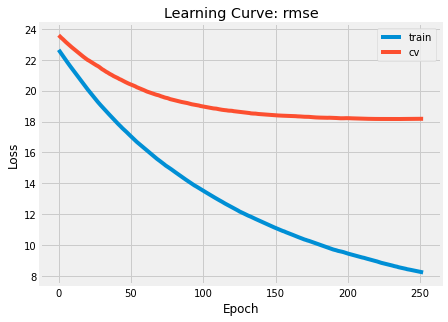

In [8]:
results = xgb_model_best.evals_result()
plotLearningCurves(results, ['rmse'])

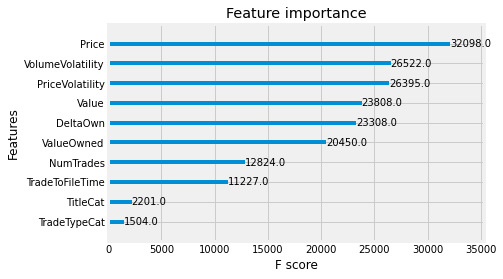

In [9]:
xgb.plot_importance(xgb_model_best)
plt.show()

### Let's visualize our predictions vs. the actual price percentage increase.

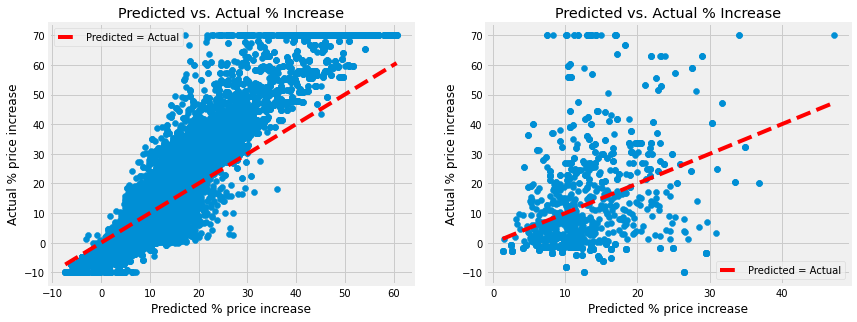

In [12]:
train_Y_preds = xgb_model_best.predict(train_X)
cv_Y_preds = xgb_model_best.predict(cv_X)

my_plots.plotPredictedVsActual(train_Y_preds, train_Y, cv_Y_preds, cv_Y)

### Everything below the dotted line is an overestimate.

That's not good: we don't want to be confident that a stock will gain a lot, onlytrain_X_purchaseso underperform! On the contrary, if a stock outperforms our expectations and we've bought into it at all, then that's great!

Let's define a custom objective function that penalizes overestimates more heavily than underestimates. It will be an asymmetric mean squared error where we penalize overestimates, say, 10 times more than underestimates. We want to be ***really*** confident that a ticker will gain.

In [13]:
def asymm_rmse(y_true, y_pred):
    '''
    This is our custom objective loss function that favors either underestimates (wgt > 1)
    or overestimates (0 < wgt < 1).
    '''
    # I'm honestly confused about when a DMatrix is passed to this function vs. an ndarray,
    # so this is a cheeky patch
    if type(y_true) != np.ndarray: y_true = y_true.get_label()

    isOverestimatedLoss = (y_true < y_pred).astype(float) * (y_true < 0).astype(float)
    isOver20 = (y_true > 20).astype(float)
    #isUnder20 = (y_true <= 20).astype(float)
    #isEstimatedBelow20 = (y_pred <= 20).astype(float)

    # first term takes care of overestimated losses and the general penalty for all incorrect guesses
    # on data under 20%; second term takes care of estimates below 20% on data above 20%
    diff = (5*isOverestimatedLoss + isOver20 + 1)*np.square(y_pred-y_true)

    loss = np.sqrt(np.mean(diff, axis=-1))

    return loss


def asymm_grads(y_true, y_pred):
    '''
    Custom objective that penalizes overestimated losses more heavily, assuming wgt > 1.

    See asymm_rmse above for the loss definition.
    '''
    isOverestimatedLoss = (y_true < y_pred).astype(float) * (y_true < 0).astype(float)
    isOver20 = (y_true > 20).astype(float)
    #isUnder20 = (y_true <= 20).astype(float)
    #isEstimatedBelow20 = (y_pred <= 20).astype(float)        

    grad = 2*(5*isOverestimatedLoss + isOver20 + 1)*(y_pred-y_true)
    hess = 2*(5*isOverestimatedLoss + isOver20 + 1)

    return grad, hess

In [14]:
xgb_model_custom_best = my_models.XGBReg(
    train_X, train_Y, cv_X, cv_Y, 
    objective=asymm_grads,  
    metric=asymm_rmse,  
    parameters=parameters, 
    earlyStopping=EARLY_STOPPING, 
    n_estimators=N_ESTIMATORS
)

Best learning_rate, min_split_loss, max_depth, max_delta_step, colsample_bytree, subsample,
reg_lambda, min_child_weight:
(0.01, 0.1, 12, 0.0, 0.8, 0.7, 2.0, 3.0)


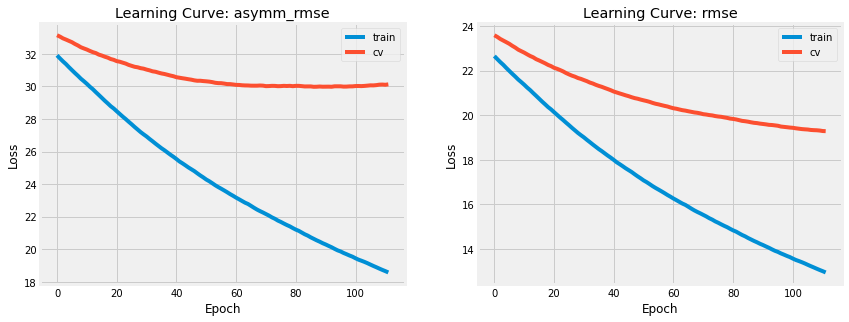

In [15]:
results_custom = xgb_model_custom_best.evals_result()

plotLearningCurves(results_custom, ['asymm_rmse', 'rmse'])

This might be a sign that we have overfit the training set. Let's compare the predicted and actual increases:

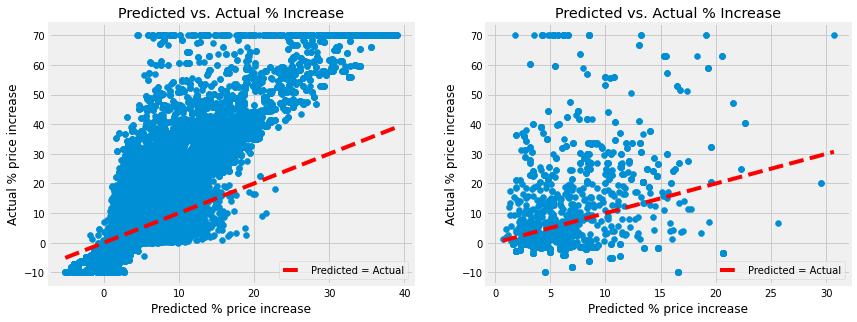

In [16]:
train_Y_preds_custom = xgb_model_custom_best.predict(train_X)
cv_Y_preds_custom = xgb_model_custom_best.predict(cv_X)
my_plots.plotPredictedVsActual(train_Y_preds_custom, train_Y, cv_Y_preds_custom, cv_Y)

TRAINING: the regressor definitely learned very well how to avoid overestimates.

CV: Well, we've certainly missed out on many large runs, including the one that was 300%+... ouch.

However, what's important is that a higher proportion of points are near or above the "predicted = actual" line, which means that our algorithm has become more conservative and hence favorable. 

It might be inevitable that we overfit the training data a bit, especially with so little data and only 16 features, as the stock market is so volatile and influenced by so many confounding factors.

This makes me think that I should perhaps only trust the algorithm when it's ***really*** confident.

### Let's visualize our categorizations with a confusion matrix.

In [17]:
def returnPriceLabels(priceChange, labels, benchmark):
    '''
    Categorizes a percentage price change via comparison to a benchmark S&P500 gain.
    '''
    if priceChange < 0:
        return labels[0]
    elif (priceChange >= 0) and (priceChange < benchmark):
        return labels[1]
    elif (priceChange >= benchmark) and (priceChange < 2*benchmark):
        return labels[2]
    elif (priceChange >= 2*benchmark) and (priceChange < 3*benchmark):
        return labels[3]
    else:
        return labels[4]

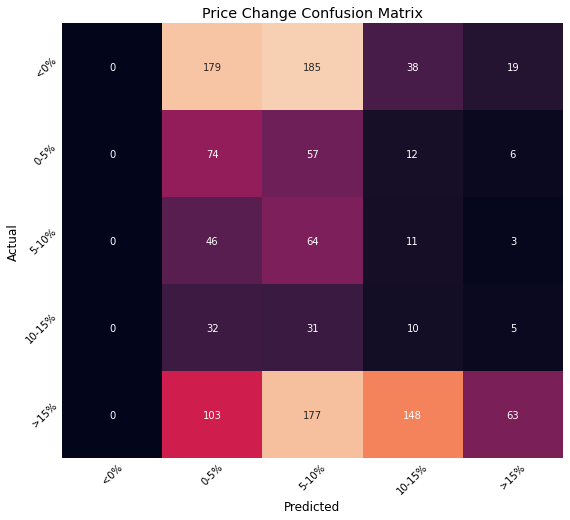

In [18]:
benchmark = 5  # sets group spacing in confusion matrix

labels = ['<0%', 
          f'0-{benchmark}%',
          f'{benchmark}-{2*benchmark}%',
          f'{2*benchmark}-{3*benchmark}%',
          f'>{3*benchmark}%']

pred_labels = [returnPriceLabels(y_pred, labels, benchmark) for y_pred in cv_Y_preds_custom]
true_labels = [returnPriceLabels(y_true, labels, benchmark) for y_true in cv_Y.to_numpy()]

confMat = confusion_matrix(true_labels, pred_labels, labels=labels)
plt.figure(figsize = (8,8))
sn.heatmap(pd.DataFrame(confMat, labels, labels), annot=True, fmt='g', cbar=False, vmin=0, vmax=200)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Price Change Confusion Matrix')
plt.show()

For something as volatile as the stock market, this is pretty decent. We're happy with predictions that generally fall on or below the diagonal, which indicates that we tend to underestimate.

In particular, look at the rightmost two columns. Our conservative algorithm performs pretty well when it makes bold estimates! Of 97 trades whose tickers were predicted to run by at least 8%, 73 actually did.

#### That's an 75% success rate on high-prediction trades!

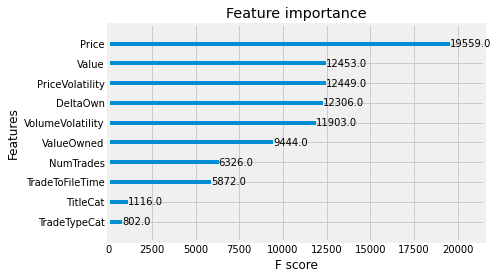

In [20]:
xgb.plot_importance(xgb_model_custom_best)
plt.show()

The feature importance map is interesting and a cause for some consideration -- current price is by far the most important indicator of future price.

I think that this can be seen as either a bit concerning, or a bit tautological. On the one hand, we'd naturally not expect price to give any sort of indication of what the future price will be -- it's just an arbitrary value! But on the other hand, even though share structure is what's actually important in determining how easily the price can jump, I suspect that it usually is such that higher-priced tickers don't tend to run as easily as lower-priced tickers. Thus, it's just inherently more likely that a \\$1 ticker increases to \\$1.10 than a \\$100 ticker increases to \\$110.

Quantity of shares owned by the insider is important, which makes sense. If they own more shares, they probably know more about the company, and their purchases and sells directly affect the ticker price more.

Surprisingly, particular insider titles don't seem to matter that much. Something to consider is looking for particular kinds of clusters of trades, e.g. multiple recent trades with at least one of them being an officer.

In [ ]:
train_and_cv.InsiderName.value_counts().head(20)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.352967 to fit


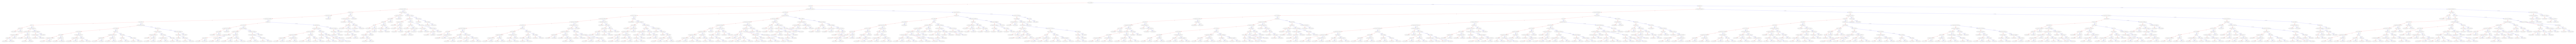

In [19]:
# Graphviz isn't on the environment's path by default for some reason, so we must add it
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

xgb.plot_tree(xgb_model_custom_best)  # plot the first tree in the model
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()
fig.savefig('outputs/regression_tree.png')

In [21]:
cv_XY['XGB_Prediction'] = cv_Y_preds_custom
my_misc.save_obj(cv_XY, 'data/cv_XY')

xgb_model_best.save_model('models/xgb_model.json')